# SARIMA Modeling
- In this notebook, baseline SARIMA modeling will be performed.
- A single building will be selected and looked at to establish a baseline model.
- Before modeling however, the building's electricity consumption will be checked for stationarity.
- Once stationarity has been verified, initial model parameters will be determined with ACF and PACF plots.
- A grid search will then be used to optimize the parameters.
- With these parameters, the model's performance will be evaluated, and walk forward validation will be performed.

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
import pickle
import math

pd.set_option('display.max_columns', None)

In [2]:
%matplotlib inline

import sys
import statsmodels as ss
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings

In [55]:
from sklearn.metrics import mean_squared_error

# Load `berkeley_df`
- Select one building to build baseline model
- Group data by day
- Create training set

In [3]:
with open('Data_Files/berkeley_clean4.pkl','rb') as read_file:
    berkeley_df = pickle.load(read_file)

## Building 580 will be used

In [4]:
berkeley580 = berkeley_df[berkeley_df['building_id'] == 580]

## Group data by date
- ARIMA, SARIMA models will likely not be able to handle the volatility of hourly data, so meter readings will be added up by day

In [6]:
berkeley580_date = berkeley580.groupby(['Date','Year','Month']).agg({'meter_reading_scraped':'sum'}).reset_index()


In [7]:
berkeley580_date['Date2'] = berkeley580_date['Date']

In [8]:
berkeley580_date = berkeley580_date.set_index('Date2', drop = True)

## Create training set
- Test set will be month of November 2019

In [20]:
train2 = berkeley580_date[(berkeley580_date['Date'].values < dt.datetime.strptime('2019-11-01 00:00:00', '%Y-%m-%d %H:%M:%S').date())]

In [27]:
train2[244:274]

,Date,Year,Month,meter_reading_scraped
Date2,,,,
2016-09-01,2016-09-01,2016,9,3365.0
2016-09-02,2016-09-02,2016,9,3243.0
2016-09-03,2016-09-03,2016,9,1595.0
2016-09-04,2016-09-04,2016,9,1212.0
2016-09-05,2016-09-05,2016,9,2231.0
2016-09-06,2016-09-06,2016,9,3452.0
2016-09-07,2016-09-07,2016,9,3700.0
2016-09-08,2016-09-08,2016,9,3081.0
2016-09-09,2016-09-09,2016,9,3022.0


# Check for Stationarity

- Data is not stationary
- As can be seen, there is a weekly trend in the data (both the line plot and ACF plot)
    - This makes sense for a school building
    - Electricity is higher during the week when school is in session, and lower
    during the weekend when there is no class

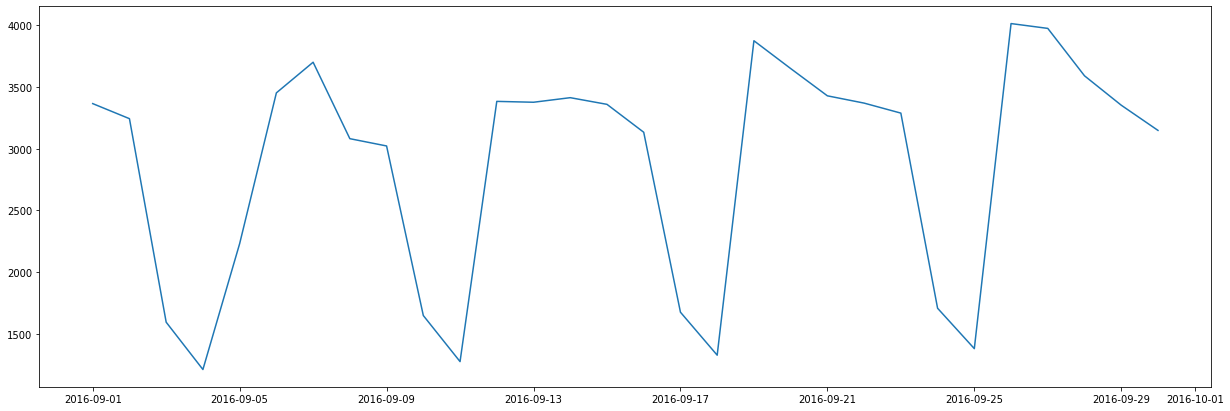

In [33]:
plt.figure(figsize=[21,7])
plt.plot(train2['meter_reading_scraped'][244:274])

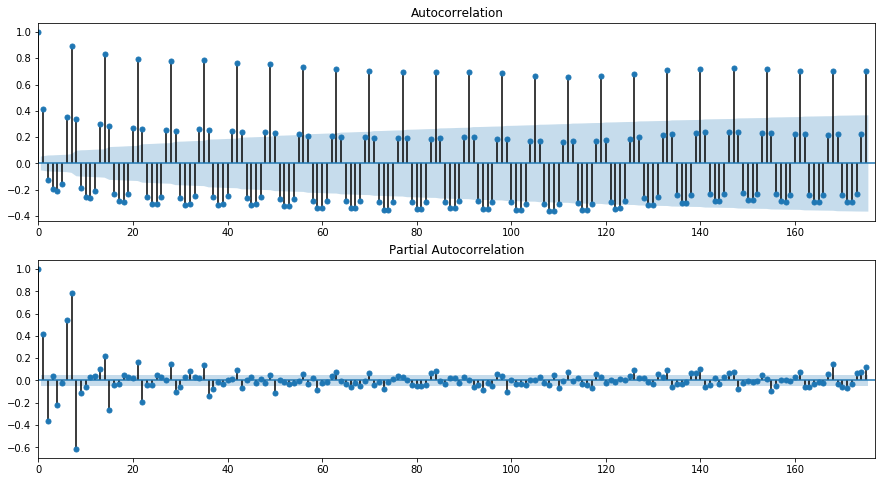

In [21]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(np.log(train2.meter_reading_scraped), lags=175, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(np.log(train2.meter_reading_scraped), lags=175, ax=ax[1])
ax[0].set_xlim(0, 177)
ax[1].set_xlim(0, 177)
plt.show()

## Make data stationary by applying differences
- Apply first and seasonal differences and see how they affect stationarity of data

In [37]:
train2_seas = train2.meter_reading_scraped.diff(7)
train2_diff = train2.meter_reading_scraped.diff()
train_both = train_seas.diff()

### First Difference
- Weekly trend is still apparent after first difference is made (in both line plot and ACF plot)

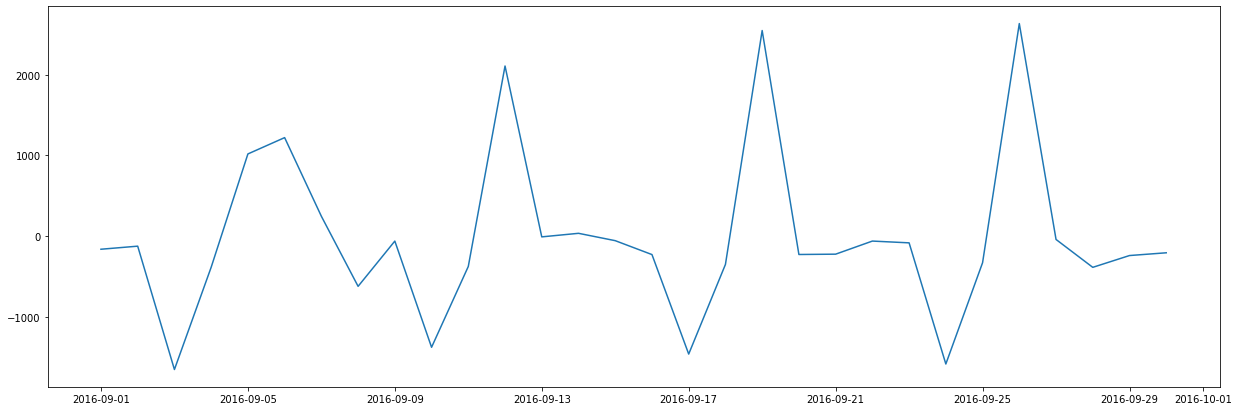

In [40]:
plt.figure(figsize=[21,7])
plt.plot(train2_diff[244:274])

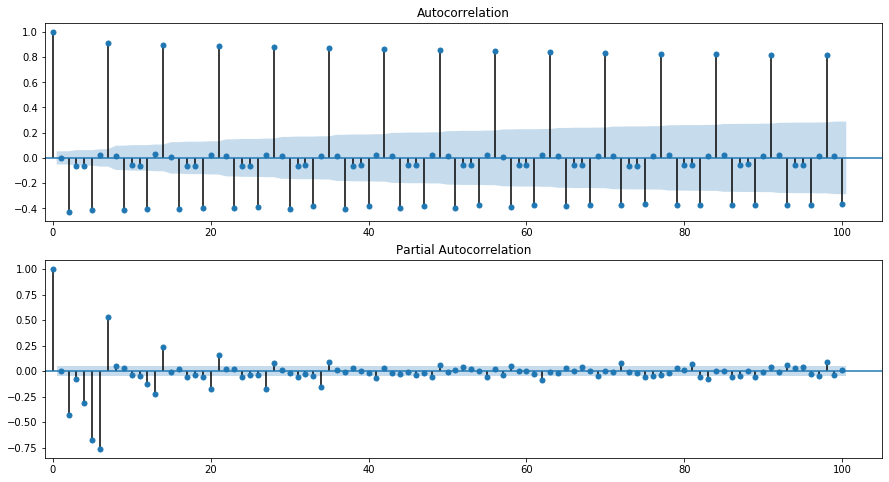

In [38]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(train2_diff[1:], lags=100, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train2_diff[1:], lags=100, ax=ax[1])
ax[0].set_xlim(-1, 105)
ax[1].set_xlim(-1, 105)
plt.show()

### First Difference + Seasonal Difference
- Weekly trend is no longer apparent, so data appears to be stationary
- Looking at ACF/PACF plots:
    - there are significant negative spikes in the ACF plot at lag 1 and lag 7
    - there are significant negative spikes at lags 1 and 2 (i.e. lags are slower to decay), as well as significant negative spikes at lags 7, 14, 21, etc.
    - For first SARIMA model, this indicates a potential parameter starting point of **SARIMA(0,1,1)x(0,1,1,7)**

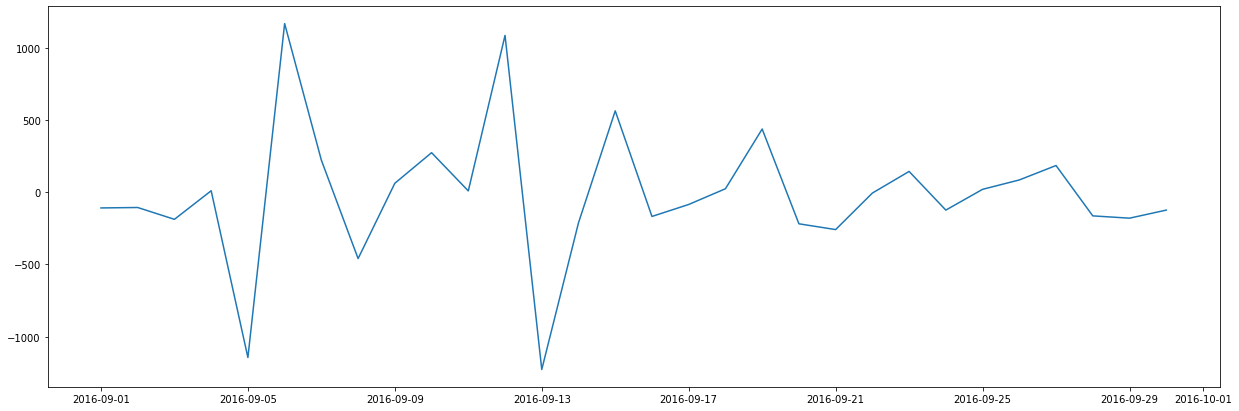

In [43]:
plt.figure(figsize=[21,7])
plt.plot(train_both[244:274])

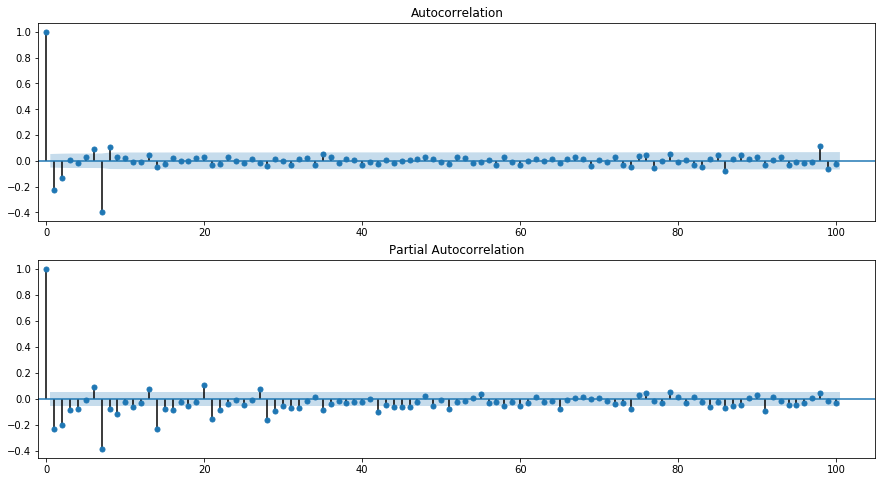

In [45]:
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(train_both[8:], lags=100, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(train_both[8:], lags=100, ax=ax[1])
ax[0].set_xlim(-1, 105)
ax[1].set_xlim(-1, 105)
plt.show()

## Verify Stationarity
- Use Augmented Dickey-Fuller Test
    - The null hypothesis (p-value > 0.05) for this test is that the data is not stationary.
    - p-value is ~ 0, which confirms that null value can be rejected; data is stationary

In [47]:
from statsmodels.tsa.stattools import adfuller
adf, pvalue, usedlag_, nobs_, critical_values_, icbest_ = adfuller(train_both[8:])



In [48]:
pvalue

2.9559534005339515e-24

# Preliminary SARIMA Model
- Implement preliminary SARIMA model using parameters identified from ACF and PACF plots.
- Verify quality of model with new ACF and PACF plots of the model's residuals.

In [50]:
# fit SARIMA based on helper plots
sar = sm.tsa.statespace.SARIMAX(np.log(train2.meter_reading_scraped), 
                                order=(0,1,1), 
                                seasonal_order=(0,1,1,7)).fit(max_iter = 50, method = 'powell')
sar.summary()

/Users/andrewgraves/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


Optimization terminated successfully.
         Current function value: -0.740755
         Iterations: 3
         Function evaluations: 126


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:             meter_reading_scraped   No. Observations:                 1400
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 7)   Log Likelihood                1037.057
Date:                           Mon, 24 Feb 2020   AIC                          -2068.113
Time:                                   16:02:26   BIC                          -2052.398
Sample:                               01-01-2016   HQIC                         -2062.237
                                    - 10-31-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4109      0.012    -35.304      0.000      -0.434      -0.388
ma.S.L7       -0.9508      0.007   -138.661      0.000      -0.964      -0.937
sigma2         0.0130      0.000     67.537      0.000       0.013       0.013
===================================================================================
Ljung-Box (Q):                      233.49   Jarque-Bera (JB):              8104.97
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.28   Skew:                            -0.79
Prob(H) (two-sided):                  0.01   Kurtosis:                        14.72
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

- **There are no significant spikes except for at lag 7 in the ACF and PACF plots of the model's residuals.**
- **These parameters are an acceptable starting point for the model and can be further improved using a grid search.**

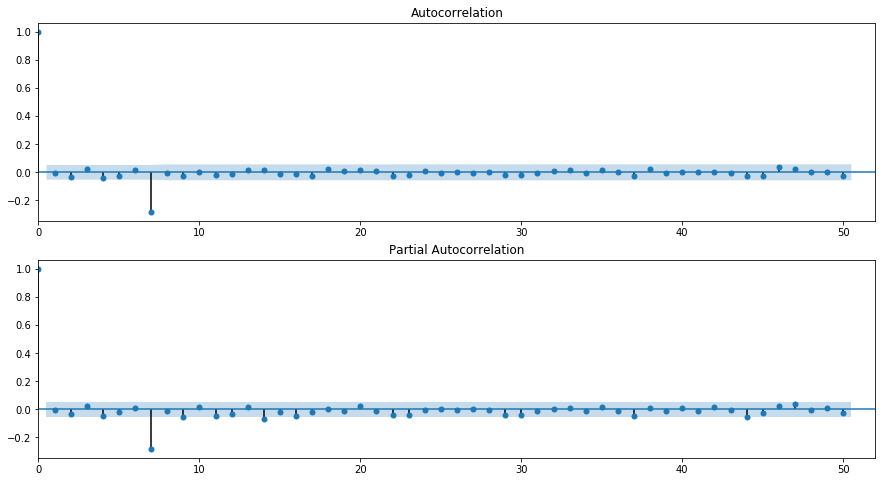

In [51]:
res = sar.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
ax[0].set_xlim(0, 52)
ax[1].set_xlim(0, 52)
plt.show()

# GridSearch
- Perform grid search to identify the best p,d,q,s parameters to use for this model.
- Compare different models using the AIC.
    - A seasonal component (s) of 7 was kept for all iterations because of the weekly trend.
    - **The best combo of parameters (i.e. the parameters that give the best AIC) is SARIMA(1,1,2)x(1,1,2,7)**

In [52]:
# SETUP (using itertools to gridsearch solutions)
import itertools

# set parameter range
p = range(0,3)
q = range(1,3)
d = range(1,2)
s = range(7,8)

# list of all parameter combos
pdq = list(itertools.product(p, d, q))
# same for seasonal variant
seasonal_pdq = list(itertools.product(p, d, q, s))

In [53]:
seasonal_pdq

[(0, 1, 1, 7),
 (0, 1, 2, 7),
 (1, 1, 1, 7),
 (1, 1, 2, 7),
 (2, 1, 1, 7),
 (2, 1, 2, 7)]

In [54]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(np.log(train2.meter_reading_scraped),
                                            order=param,
                                            seasonal_order=param_seasonal)
            results = mod.fit(max_iter = 50, method = 'powell')

            print('SARIMA{},{}7 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

Optimization terminated successfully.
         Current function value: -0.740755
         Iterations: 3
         Function evaluations: 126
SARIMA(0, 1, 1),(0, 1, 1, 7)7 - AIC:-2068.11336633084
Optimization terminated successfully.
         Current function value: -0.759386
         Iterations: 3
         Function evaluations: 173
SARIMA(0, 1, 1),(0, 1, 2, 7)7 - AIC:-2118.282193120855
Optimization terminated successfully.
         Current function value: -0.761877
         Iterations: 4
         Function evaluations: 209
SARIMA(0, 1, 1),(1, 1, 1, 7)7 - AIC:-2125.254877130879
Optimization terminated successfully.
         Current function value: -0.763044
         Iterations: 10
         Function evaluations: 680
SARIMA(0, 1, 1),(1, 1, 2, 7)7 - AIC:-2126.5232645310407
Optimization terminated successfully.
         Current function value: -0.762881
         Iterations: 7
         Function evaluations: 474
SARIMA(0, 1, 1),(2, 1, 1, 7)7 - AIC:-2126.066827316302
Optimization terminated succe

# Analyze Selected Model
- Predict values of test set, and evaluate performance of models
- Plot results to get visual representation of model's performance

In [57]:
# fit SARIMA based on helper plots
sar = sm.tsa.statespace.SARIMAX(np.log(train2.meter_reading_scraped), 
                                order=(1,1,2), 
                                seasonal_order=(1,1,2,7)).fit(max_iter = 50, method = 'powell')
sar.summary()

Optimization terminated successfully.
         Current function value: -0.792255
         Iterations: 15
         Function evaluations: 1317


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:             meter_reading_scraped   No. Observations:                 1400
Model:             SARIMAX(1, 1, 2)x(1, 1, 2, 7)   Log Likelihood                1109.156
Date:                           Mon, 24 Feb 2020   AIC                          -2204.313
Time:                                   16:19:19   BIC                          -2167.643
Sample:                               01-01-2016   HQIC                         -2190.601
                                    - 10-31-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8372      0.015     55.769      0.000       0.808       0.867
ma.L1         -1.2215      0.023    -52.364      0.000      -1.267      -1.176
ma.L2          0.2265      0.021     10.760      0.000       0.185       0.268
ar.S.L7        0.4827      0.083      5.827      0.000       0.320       0.645
ma.S.L7       -1.2235      0.238     -5.148      0.000      -1.689      -0.758
ma.S.L14       0.2237      0.105      2.128      0.033       0.018       0.430
sigma2         0.0116      0.002      4.762      0.000       0.007       0.016
===================================================================================
Ljung-Box (Q):                       63.79   Jarque-Bera (JB):             10615.07
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                            -1.55
Prob(H) (two-sided):                  0.01   Kurtosis:                        16.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predict Electricity Consumption for November 2019

In [58]:
# sar.plot_diagnostics()

In [60]:
def unlog_pred(log_pred):
    
    pred = [math.exp(i) for i in log_pred.values]
    pred = pd.Series(pred, index = log_pred.index)
    
    return pred

In [63]:
pred_forecast_log = sar.get_forecast(steps = 30)
pred_forecast = unlog_pred(pred_forecast_log.predicted_mean)

## Evaluate Predicted Values
- Look at both mean absolute error and root mean squared error
- **MAPE: 11.7%**
- Additionally:
    - Normality
    - Ljung-Box
    - Heteroskedasticity
    - Durbin-Watson

### Mean Absolute Error and Mean Absolute Percent Error

In [73]:
mape = (abs(fcast-true)/true)*100

In [74]:
mape.mean()

11.65573210360271

### Root Mean Squared Error

In [69]:
# compute mean square error
fcast = pred_forecast.values
true = berkeley580_plot[dt.date(2019, 11, 1):]['meter_reading_scraped'].values

mse_score = ((fcast - true) ** 2).mean()
print('MSE of our forecasts is {}'.format(round(mse_score, 3)))

MSE of our forecasts is 148188.063


In [70]:
rmse = math.sqrt(mse_score)
rmse

384.952026890936

In [75]:
# create and run statistical tests on model
norm_val, norm_p, skew, kurtosis = sar.test_normality('jarquebera')[0]
lb_val, lb_p = sar.test_serial_correlation(method='ljungbox')[0]
het_val, het_p = sar.test_heteroskedasticity('breakvar')[0]

# we want to look at largest lag for Ljung-Box, so take largest number in series
# there's intelligence in the method to determine how many lags back to calculate this stat
lb_val = lb_val[-1]
lb_p = lb_p[-1]
durbin_watson = sm.stats.stattools.durbin_watson(sar.filter_results.standardized_forecasts_error[0, sar.loglikelihood_burn:])

print('Normality: val={:.3f}, p={:.3f}'.format(norm_val, norm_p));
print('Ljung-Box: val={:.3f}, p={:.3f}'.format(lb_val, lb_p));
print('Heteroskedasticity: val={:.3f}, p={:.3f}'.format(het_val, het_p));
print('Durbin-Watson: d={:.2f}'.format(durbin_watson))

Normality: val=10615.071, p=0.000
Ljung-Box: val=63.791, p=0.010
Heteroskedasticity: val=1.267, p=0.011
Durbin-Watson: d=1.97


## Plot Predictions vs Actual Values

In [64]:
berkeley580_plot = pd.DataFrame(berkeley580_date['meter_reading_scraped'])

In [66]:
berkeley580_plot[:10]

,meter_reading_scraped
Date2,
2016-01-01,1772.0
2016-01-02,1337.0
2016-01-03,1284.0
2016-01-04,2017.0
2016-01-05,1933.0
2016-01-06,1988.0
2016-01-07,2059.0
2016-01-08,1990.0
2016-01-09,1364.0


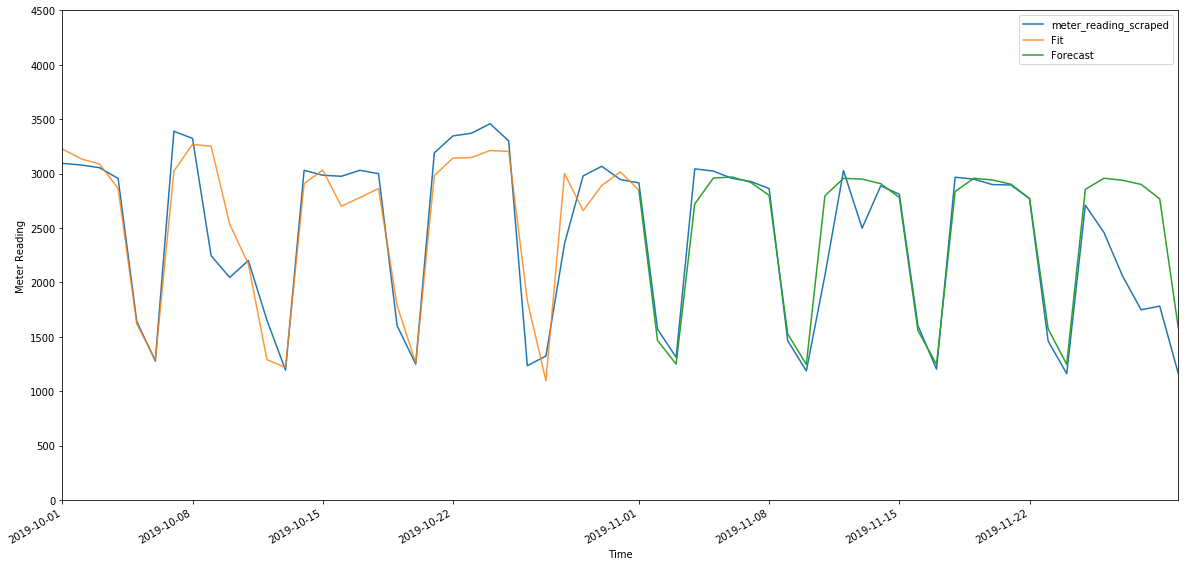

In [67]:
# plot predictions

ax = berkeley580_plot.plot(label='Observed Meter Readings', figsize=(20,10))
sar_pred.plot(ax=ax, label='Fit', alpha=.8) # this is using all available info
pred_forecast.plot(ax = ax, label='Forecast')

# ax.fill_between(sar_pred_ci.index, sar_pred_ci.iloc[:, 0], sar_pred_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlim(dt.date(2019, 10, 1), dt.date(2019, 11, 30))
ax.set_ylim(0, 4500)
ax.set_xlabel('Time')
ax.set_ylabel('Meter Reading')
plt.legend()

# Walk Forward Validation

- Verify performance of model with walk forward validation
- Performance will be evaluate one week at a time for the month of November 2019, i.e...
    - first run through will evaluate first week of November 2019
    - second run through will evaluate second week of November 2019 (with first week added to training set)
    - third run through will evaluate third week of November 2019 (with first and second weeks added to training set)
    - fourth run through will evaluate fourth week of November 2019 (with first, second, third, weeks added to training set)
- Average MAPE across the four walks of validation: **9.77%**

In [76]:
X = np.log(berkeley580_date.meter_reading_scraped.values)
time = berkeley580_date.index

In [77]:
def train_test_split(data, n_test):
    return data[:n_test], data[n_test:]

In [78]:
train, test = train_test_split(X, 1400)

In [79]:
walk_index = list(train2.Date.values)

In [80]:
X = np.log(berkeley580_date.meter_reading_scraped.values)
# walk forward validation in a step by step manner
def walk_forward_validation(data, n_test, end_date):
    predictions = []
    mae_list = []
    first_index = walk_index
    train, test = train_test_split(data, n_test)
    history = [x for x in train] #seed history with training data
    i_list = [7,14,21,28]
    for index, i in enumerate(i_list):  
        
        j = i-7
        model = sm.tsa.statespace.SARIMAX(pd.Series(history, index = first_index), order=(1,1,2), 
                                                    seasonal_order=(1,1,2,7)).fit(max_iter = 50, method = 'powell')
        
        pred_forecast_log = model.get_forecast(steps = 7)
        pred_forecast = unlog_pred(pred_forecast_log.predicted_mean)
        predictions = np.concatenate((predictions, pred_forecast), axis=None)
        
        mae_test = np.array([math.exp(num) for num in test[j:i]])
        mae_score = (abs(mae_test-predictions[j:i])/mae_test)*100
        mae_mean = mae_score.mean()
        print(mae_mean)
        mae_list.append(mae_mean)
        print('-------------------')
                                          
        history = np.concatenate((history, test[j:i]), axis=None) #add it to history for next loop
        end_date = pd.to_datetime(end_date) + timedelta(days=7)
        
        i = 0
        for i in range(7):
            add_day = [first_index[-1] + timedelta(days=1)]
            first_index.extend(add_day)
            i += 1
    
    mae = np.array(mae_list).mean()

    return predictions, mae

In [81]:
walk_pred, walk_mae = walk_forward_validation(X, 1400, '2019-11-01')

Optimization terminated successfully.
         Current function value: -0.792255
         Iterations: 15
         Function evaluations: 1317
3.861674322824847
-------------------
Optimization terminated successfully.
         Current function value: -0.794586
         Iterations: 15
         Function evaluations: 1345
10.376460085811383
-------------------
Optimization terminated successfully.
         Current function value: -0.792159
         Iterations: 16
         Function evaluations: 1454
4.546230104895404
-------------------
Optimization terminated successfully.
         Current function value: -0.793819
         Iterations: 15
         Function evaluations: 1391
20.30877225897569
-------------------


In [83]:
np.array(walk_mae).mean()

9.77328419312683

In [44]:
# def unlog(list_of_series):
    
#     unlog_list = []
#     unlog_dict = {}
    
#     for enum, series in enumerate(list_of_series):
#         unlog_list = []
#         for index, values in series.iteritems():
#             unlog_list.append(math.exp(values))
#             unlog_dict[enum] = unlog_list
#         continue
   
#     return unlog_dict

## Visualize Walk Forward Validation

### Prediction for Entire Month

In [85]:
pred_index = [pd.to_datetime('2019-11-01')]
add_day = pd.to_datetime('2019-11-01')
i = 0
for i in range(28):
    add_day += timedelta(days=1)
    add_day_list = [add_day]
    pred_index.extend(add_day_list)
    i += 1


(0, 5000)

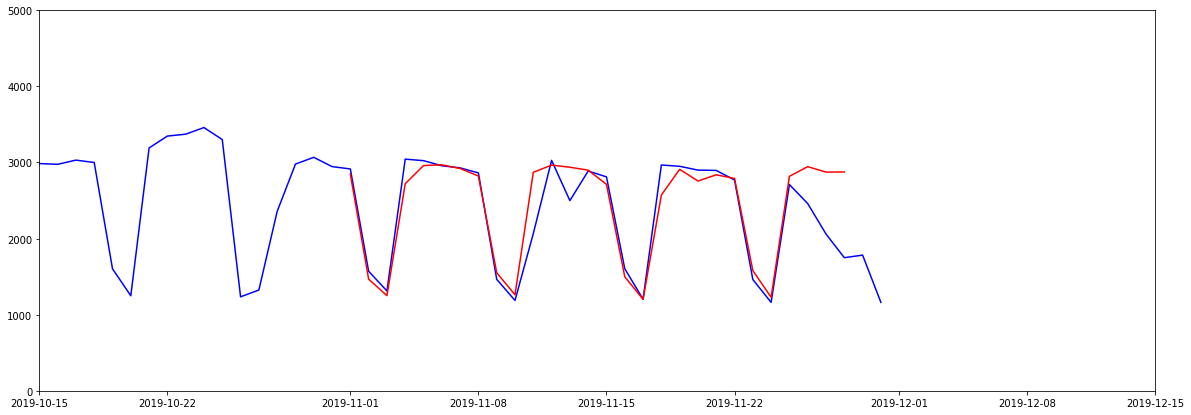

In [93]:
plt.figure(figsize=[20,7])
plt.plot(berkeley580_plot, 'b')
plt.plot(pred_index[:-1], walk_pred, 'r')
plt.xlim(dt.datetime(2019,10,15), dt.datetime(2019,12,15))
plt.ylim(0, 5000)

### Prediction by Week

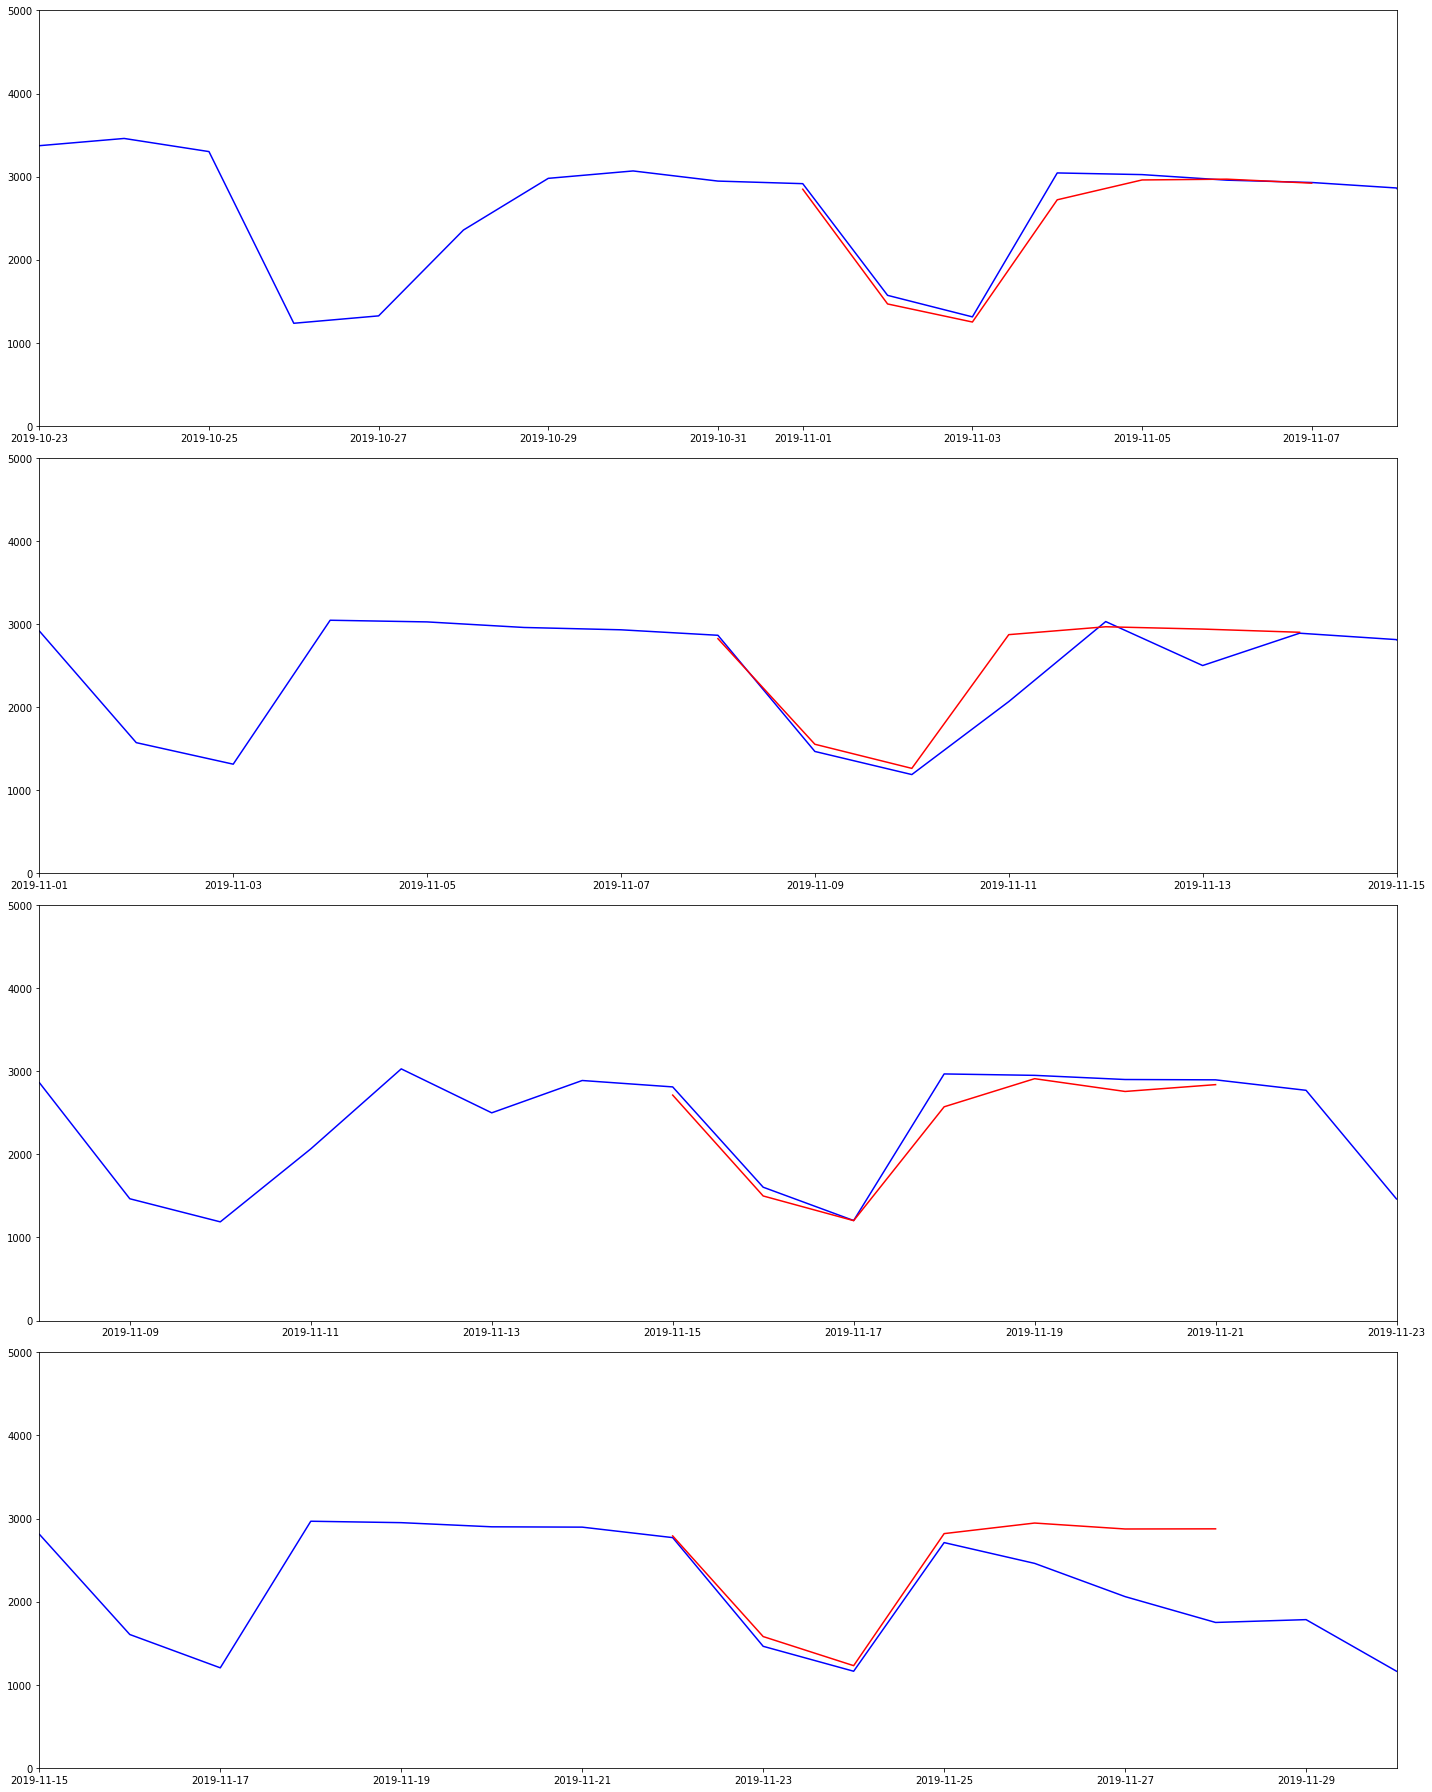

In [100]:
plt.figure(figsize=[20,25])
plt.title('Walk Forward Validation', fontsize=20)

plt.subplot(4,1,1)
plt.plot(berkeley580_plot, 'b')
plt.plot(berkeley580_plot[-30:-23].index, walk_pred[:7], 'r')
plt.xlim(dt.datetime(2019,10,23), dt.datetime(2019,11,8))
plt.ylim(0, 5000)

plt.subplot(4,1,2)
plt.plot(berkeley580_plot, 'b')
plt.plot(berkeley580_plot[-23:-16].index, walk_pred[7:14], 'r')
plt.xlim(dt.datetime(2019,11,1), dt.datetime(2019,11,15))
plt.ylim(0, 5000)

plt.subplot(4,1,3)
plt.plot(berkeley580_plot, 'b')
plt.plot(berkeley580_plot[-16:-9].index, walk_pred[14:21], 'r')
plt.xlim(dt.datetime(2019,11,8), dt.datetime(2019,11,23))
plt.ylim(0, 5000)

plt.subplot(4,1,4)
plt.plot(berkeley580_plot, 'b')
plt.plot(berkeley580_plot[-9:-2].index, walk_pred[21:28], 'r')
plt.xlim(dt.datetime(2019,11,15), dt.datetime(2019,11,30))
plt.ylim(0, 5000)

plt.tight_layout()

**Given the success of the walk-forward validation, this model will be applied to the rest of the buildings on the UC Berkeley campus in the "New_SARIMA_More_Buildings_Validation" notebook.**

---

In [ ]:
# # walk forward validation in a step by step manner
# def walk_forward_validation(data, n_test):
#     predictions = []
#     train, test = train_test_split(data, n_test)
#     history = np.concatenate((train,test[:185]), axis=None) #seed history with training data
#     i_list = [367,549,731,913,1095,1277]
#       # walk forward
#     for index, i in enumerate(i_list):
#         print('index:', index)
#         if index < 5:
#             delta = 182
#         else:
#             delta = 150
#         print('delta:', delta)
#         print('i:', i)
#         j = i - delta
#         print('j:', j)
#         print('Length of history', len(history))
#         print('len(history)-delta:', len(history)-delta)
#         # fit model and make forecast for history
#         model = sm.tsa.statespace.SARIMAX(pd.Series(history, index = time[:len(history)]), 
#                                 order=(1,1,2), 
#                                 seasonal_order=(1,1,2,7)).fit(max_iter = 50, method = 'powell')

#         log_pred = model.get_prediction(start=time[len(history)-delta], dynamic=False) # predict 367 to 549
#         log_pred = log_pred.predicted_mean
        
#         print('Length of log_pred:', len(log_pred))
#         print('---------')
#         predictions.append(log_pred)
# #         predictions.extend(y) #store the forecast
#         history = np.concatenate((history, test[j:i]), axis=None) #add it to history for next loop
#     # estimate error
# #     error = measure_rmse(test, predictions)
# #     print(' > %.3f' % error)
#     return history, predictions